<a href="https://colab.research.google.com/github/Catatau52/Carteira_Quant/blob/main/Etapa_01_Fazendo_indicadores.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install ta

In [2]:
import pandas as pd
import os
import numpy as np
from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm
from google.colab import drive
drive.mount('/content/drive')

#import ta

Mounted at /content/drive


#Funções de Indicadores

In [3]:

#A COLUNA COM O INDICADOR TEM QUE SE CHAMAR "valor"

class MakeIndicator():

    def __init__(self, caminho_dados):

        os.chdir(caminho_dados)

    def fazer_indicador_momento(self, meses):

        cotacoes = pd.read_parquet('cotacoes.parquet')
        cotacoes['data'] = pd.to_datetime(cotacoes['data']).dt.date
        cotacoes = cotacoes[['data', 'ticker', 'preco_fechamento_ajustado']]

        cotacoes['valor'] = cotacoes.groupby('ticker')['preco_fechamento_ajustado'].pct_change(periods = (meses * 21))
        cotacoes.loc[cotacoes['valor'] == 0, 'valor'] = pd.NA
        cotacoes.loc[cotacoes['valor'] == np.inf, 'valor'] = pd.NA
        cotacoes = cotacoes.dropna()
        valor = cotacoes[['data', 'ticker', 'valor']]

        valor.to_parquet(f'momento_{meses}_meses.parquet', index = False)

    def volume_mediano(self):

        cotacoes = pd.read_parquet('cotacoes.parquet')
        cotacoes['data'] = pd.to_datetime(cotacoes['data']).dt.date

        cotacoes = cotacoes[['data', 'ticker', 'volume_negociado']]
        cotacoes['volume_negociado'] = cotacoes.groupby('ticker')['volume_negociado'].fillna(0)
        cotacoes['valor'] = cotacoes.groupby('ticker')['volume_negociado'].rolling(21).median().reset_index(0,drop=True)
        cotacoes = cotacoes.dropna()
        valor = cotacoes[['data', 'ticker', 'valor']]

        valor.to_parquet(f'indicador_volume_mediano.parquet', index = False)


    def ebit_divida_liquida(self):

        df_ebit = pd.read_parquet('Ebit12m.parquet')
        df_ebit = df_ebit.assign(id_dado = df_ebit['ticker'].astype(str) + "_" + df_ebit['data'].astype(str))
        df_ebit['valor'] = df_ebit['valor'].astype(float)
        df_ebit = df_ebit[['ticker', 'data', 'id_dado', 'valor']]
        df_ebit.columns = ['ticker', 'data', 'id_dado', 'ebit']

        df_divida_liquida = pd.read_parquet('DividaLiquida.parquet')
        df_divida_liquida = df_divida_liquida.assign(id_dado = df_divida_liquida['ticker'].astype(str) + "_" + df_divida_liquida['data'].astype(str))
        df_divida_liquida['valor'] = df_divida_liquida['valor'].astype(float)
        df_divida_liquida = df_divida_liquida[['id_dado', 'valor']]
        df_divida_liquida.columns = ['id_dado', 'divida']

        df_indicadores = pd.merge(df_ebit, df_divida_liquida, how = 'inner', on = 'id_dado')
        df_indicadores['ebit_DL'] = pd.NA
        df_indicadores.loc[df_indicadores['divida'] <= 0, 'ebit_DL'] = 999
        df_indicadores.loc[df_indicadores['ebit'] <= 0, 'ebit_DL'] = -999
        df_indicadores.loc[df_indicadores['ebit_DL'].isna(), 'ebit_DL'] = (df_indicadores[df_indicadores['ebit_DL'].isna()]['ebit']/
                                                                df_indicadores[df_indicadores['ebit_DL'].isna()]['divida'])
        df_indicadores = df_indicadores[['data', 'ticker', 'ebit_DL']]
        df_indicadores.columns = ['data', 'ticker', 'valor']

        df_indicadores.to_parquet(f'ebit_divliq.parquet', index = False)


    def pl_divida_bruta(self):

        df_pl = pd.read_parquet('PatrimonioLiquido.parquet')
        df_pl = df_pl.dropna()
        df_pl = df_pl.assign(id_dado = df_pl['ticker'].astype(str) + "_" + df_pl['data'].astype(str))
        df_pl['valor'] = df_pl['valor'].astype(float)
        df_pl = df_pl[['data', 'ticker', 'valor', 'id_dado']]
        df_pl.columns = ['data', 'ticker', 'patrimonio_liquido', 'id_dado']
        #print(df_pl)
        df_divida_bruta = pd.read_parquet('DividaBruta.parquet')
        df_divida_bruta[df_divida_bruta['valor'] == '0.0'] = pd.NA
        df_divida_bruta = df_divida_bruta.dropna()
        df_divida_bruta = df_divida_bruta.assign(id_dado = df_divida_bruta['ticker'].astype(str) + "_" + df_divida_bruta['data'].astype(str))
        df_divida_bruta['valor'] = df_divida_bruta['valor'].astype(float)
        df_divida_bruta = df_divida_bruta[['id_dado', 'valor']]
        df_divida_bruta.columns = ['id_dado', 'divida']
        #print(df_divida_bruta)
        df_indicadores = pd.merge(df_pl, df_divida_bruta, how = 'inner', on = 'id_dado')
        df_indicadores['PL_DB'] = pd.NA
        df_indicadores.loc[df_indicadores['patrimonio_liquido'] <= 0, 'PL_DB'] = 0
        df_indicadores.loc[df_indicadores['PL_DB'].isna(), 'PL_DB'] = (df_indicadores[df_indicadores['PL_DB'].isna()]['patrimonio_liquido']/
                                                                df_indicadores[df_indicadores['PL_DB'].isna()]['divida'])
        df_indicadores = df_indicadores[['data', 'ticker', 'PL_DB']]
        df_indicadores.columns = ['data', 'ticker', 'valor']
        #print(df_indicadores)
        df_indicadores.to_parquet('pl_db.parquet', index = False)

    def beta(self, anos):

        cotacoes = pd.read_parquet('cotacoes.parquet')
        cotaoces_ibov = pd.read_parquet('ibov.parquet')


        cotaoces_ibov.loc['5846'] = ['2023-08-10', 118349.60]

        cotaoces_ibov['retorno_ibov'] = cotaoces_ibov['fechamento'].pct_change()
        cotaoces_ibov = cotaoces_ibov[['data', 'retorno_ibov']]
        cotaoces_ibov['data'] = pd.to_datetime(cotaoces_ibov['data']).dt.date

        cotacoes['data'] = pd.to_datetime(cotacoes['data']).dt.date
        cotacoes = cotacoes[['data', 'ticker', 'preco_fechamento_ajustado']]
        cotacoes['retorno'] = cotacoes.groupby('ticker')['preco_fechamento_ajustado'].pct_change()
        cotacoes.loc[cotacoes['retorno'] == 0, 'retorno'] = pd.NA
        cotacoes.loc[cotacoes['retorno'] == np.inf, 'retorno'] = pd.NA

        dados_totais = pd.merge(cotacoes, cotaoces_ibov, on='data', how='inner')

        empresas = dados_totais['ticker'].unique()
        dados_totais = dados_totais.set_index('ticker')
        lista_df_betas = []

        for empresa in empresas:

            dado_empresa = dados_totais.loc[empresa]

            if dado_empresa.dropna().empty == False:

                if len(dado_empresa) > int(252 * anos):

                    datas = dado_empresa.data.values
                    exog = sm.add_constant(dado_empresa.retorno_ibov)
                    model = RollingOLS(endog=dado_empresa.retorno.values, exog=exog,
                                    window=int(252 * anos), min_nobs = int(252 * anos * 0.8))
                    betas = model.fit()
                    betas = betas.params
                    dado_empresa = betas.reset_index()
                    dado_empresa['data'] = datas
                    dado_empresa.columns = ['ticker', 'const', 'valor', 'data']
                    dado_empresa = dado_empresa[['data', 'ticker', 'valor']]
                    dado_empresa = dado_empresa.dropna()
                    lista_df_betas.append(dado_empresa)

        betas = pd.concat(lista_df_betas)
        betas.to_parquet(f'indicador_beta_{int(252 * anos)}.parquet', index = False)


    def media_movel_proporcao(self, mm_curta, mm_longa):

        cotacoes = pd.read_parquet('cotacoes.parquet')
        cotacoes['data'] = pd.to_datetime(cotacoes['data']).dt.date
        cotacoes = cotacoes[['data', 'ticker', 'preco_fechamento_ajustado']]
        cotacoes['media_curta'] = cotacoes.groupby('ticker')['preco_fechamento_ajustado'].rolling(window=mm_curta, min_periods=int(mm_curta * 0.8)).mean().reset_index(0,drop=True)
        cotacoes['media_longa'] = cotacoes.groupby('ticker')['preco_fechamento_ajustado'].rolling(window=mm_longa, min_periods=int(mm_longa * 0.8)).mean().reset_index(0,drop=True)
        cotacoes['valor'] = cotacoes['media_curta']/cotacoes['media_longa']
        valor = cotacoes[['data', 'ticker', 'valor']]
        valor = valor.dropna()

        valor.to_parquet(f'mm_{mm_curta}_{mm_longa}.parquet', index = False)


    def volatilidade_anual(self, anos):

        cotacoes = pd.read_parquet('cotacoes.parquet')
        cotacoes['data'] = pd.to_datetime(cotacoes['data']).dt.date
        cotacoes = cotacoes[['data', 'ticker', 'preco_fechamento_ajustado']]
        cotacoes['retorno'] = cotacoes.groupby('ticker')['preco_fechamento_ajustado'].pct_change()
        cotacoes.loc[cotacoes['retorno'] == 0, 'retorno'] = pd.NA
        cotacoes.loc[cotacoes['retorno'] == np.inf, 'retorno'] = pd.NA
        cotacoes['valor'] = cotacoes.groupby('ticker')['retorno'].rolling(window=int(252 * anos), min_periods=int(252 * anos * 0.8)).std().reset_index(0,drop=True)
        cotacoes = cotacoes.dropna()
        cotacoes['valor'] = cotacoes['valor'] * np.sqrt(252)
        valor = cotacoes[['data', 'ticker', 'valor']]

        valor.to_parquet(f'vol_{int(252 * anos)}_anos.parquet', index = False)

    #################################   NEW   ##################################

    def volatilidade_mensal(self, anos):

        cotacoes = pd.read_parquet('cotacoes.parquet')
        cotacoes['data'] = pd.to_datetime(cotacoes['data']).dt.date
        cotacoes = cotacoes[['data', 'ticker', 'preco_fechamento_ajustado']]
        cotacoes['retorno'] = cotacoes.groupby('ticker')['preco_fechamento_ajustado'].pct_change()
        cotacoes.loc[cotacoes['retorno'] == 0, 'retorno'] = pd.NA
        cotacoes.loc[cotacoes['retorno'] == np.inf, 'retorno'] = pd.NA
        cotacoes['valor'] = cotacoes.groupby('ticker')['retorno'].rolling(window=int(252 * anos), min_periods=int(252 * anos * 0.8)).std().reset_index(0,drop=True)
        cotacoes = cotacoes.dropna()
        cotacoes['valor'] = (cotacoes['valor'] * np.sqrt(252))/np.sqrt(12)  # Divide pela raiz quadrada de 12 para ajustar para volatilidade mensal
        valor = cotacoes[['data', 'ticker', 'valor']]

        valor.to_parquet(f'vol_mensal.parquet', index = False)

    def volatilidade_semanal(self, anos):

        cotacoes = pd.read_parquet('cotacoes.parquet')
        cotacoes['data'] = pd.to_datetime(cotacoes['data']).dt.date
        cotacoes = cotacoes[['data', 'ticker', 'preco_fechamento_ajustado']]
        cotacoes['retorno'] = cotacoes.groupby('ticker')['preco_fechamento_ajustado'].pct_change()
        cotacoes.loc[cotacoes['retorno'] == 0, 'retorno'] = pd.NA
        cotacoes.loc[cotacoes['retorno'] == np.inf, 'retorno'] = pd.NA
        cotacoes['valor'] = cotacoes.groupby('ticker')['retorno'].rolling(window=int(252 * anos), min_periods=int(252 * anos * 0.8)).std().reset_index(0,drop=True)
        cotacoes = cotacoes.dropna()
        cotacoes['valor'] = (cotacoes['valor'] * np.sqrt(252))/np.sqrt(52)  # Divide pela raiz quadrada de 52 para ajustar para volatilidade semanal
        valor = cotacoes[['data', 'ticker', 'valor']]

        valor.to_parquet(f'vol_semanal.parquet', index = False)

    def valor_patrimonial_acao(self):

        df_totalacoes = pd.read_parquet('TotalAcoes.parquet')
        df_totalacoes = df_totalacoes.assign(id_dado = df_totalacoes['ticker'].astype(str) + "_" + df_totalacoes['data'].astype(str))
        df_totalacoes['valor'] = df_totalacoes['valor'].astype(float)
        df_totalacoes = df_totalacoes[['ticker', 'data', 'valor', 'id_dado']]
        df_totalacoes.columns = ['ticker', 'data', 'TotalAcoes','id_dado']
        #print(df_totalacoes)

        df_pl = pd.read_parquet('PatrimonioLiquido.parquet')
        df_pl = df_pl.dropna()
        df_pl = df_pl.assign(id_dado = df_pl['ticker'].astype(str) + "_" + df_pl['data'].astype(str))
        df_pl['valor'] = df_pl['valor'].astype(float)
        df_pl = df_pl[['valor', 'id_dado']]
        df_pl.columns = ['patrimonio_liquido', 'id_dado']
        #print(df_pl)
        df_indicadores = pd.merge(df_pl, df_totalacoes, how = 'inner', on = 'id_dado')
        df_indicadores['PL_TA'] = pd.NA
        df_indicadores.loc[df_indicadores['patrimonio_liquido'] == 0, 'PL_TA'] = 0
        df_indicadores.loc[df_indicadores['TotalAcoes'] == 0, 'PL_TA'] = 0
        #print(df_indicadores)
        df_indicadores.loc[df_indicadores['PL_TA'].isna(), 'PL_TA'] = (df_indicadores[df_indicadores['PL_TA'].isna()]['patrimonio_liquido']/
                                                                df_indicadores[df_indicadores['PL_TA'].isna()]['TotalAcoes'])
        df_indicadores = df_indicadores[['data', 'ticker', 'PL_TA']]
        df_indicadores.columns = ['data', 'ticker', 'valor']
        #print(df_indicadores)
        df_indicadores.to_parquet('indicador_vpa.parquet', index = False)

    def lucro_acao(self):

        df_totalacoes = pd.read_parquet('TotalAcoes.parquet')
        df_totalacoes = df_totalacoes.assign(id_dado = df_totalacoes['ticker'].astype(str) + "_" + df_totalacoes['data'].astype(str))
        df_totalacoes['valor'] = df_totalacoes['valor'].astype(float)
        df_totalacoes = df_totalacoes[['ticker', 'data', 'valor', 'id_dado']]
        df_totalacoes.columns = ['ticker', 'data', 'TotalAcoes','id_dado']
        #print(df_totalacoes)

        df_lucro = pd.read_parquet('LucroLiquido12m.parquet')
        df_lucro = df_lucro.dropna()
        df_lucro = df_lucro.assign(id_dado = df_lucro['ticker'].astype(str) + "_" + df_lucro['data'].astype(str))
        df_lucro['valor'] = df_lucro['valor'].astype(float)
        df_lucro = df_lucro[['valor', 'id_dado']]
        df_lucro.columns = ['LucroLiquido', 'id_dado']
        #print(df_lucro)
        df_indicadores = pd.merge(df_lucro, df_totalacoes, how = 'inner', on = 'id_dado')
        df_indicadores['LPA'] = pd.NA
        #df_indicadores.loc[df_indicadores['LucroLiquido'] <= 0, 'LPA'] = 0
        #print(df_indicadores)
        df_indicadores['LPA'] = df_indicadores['LucroLiquido'] / df_indicadores['TotalAcoes']
        df_indicadores = df_indicadores[['data', 'ticker', 'LPA']]
        df_indicadores.columns = ['data', 'ticker', 'valor']
        #print(df_indicadores)
        df_indicadores.to_parquet('indicador_lpa.parquet', index = False)

    def lucro_ValorDeMercado(self):

        df_ValorDeMercado = pd.read_parquet('ValorDeMercado.parquet')
        df_ValorDeMercado = df_ValorDeMercado.assign(id_dado = df_ValorDeMercado['ticker'].astype(str) + "_" + df_ValorDeMercado['data'].astype(str))
        df_ValorDeMercado['valor'] = df_ValorDeMercado['valor'].astype(float)
        df_ValorDeMercado = df_ValorDeMercado[['ticker', 'data', 'valor', 'id_dado']]
        df_ValorDeMercado.columns = ['ticker', 'data', 'ValorDeMercado','id_dado']
        #print(df_ValorDeMercado)

        df_lucro = pd.read_parquet('LucroLiquido12m.parquet')
        df_lucro = df_lucro.dropna()
        df_lucro = df_lucro.assign(id_dado = df_lucro['ticker'].astype(str) + "_" + df_lucro['data'].astype(str))
        df_lucro['valor'] = df_lucro['valor'].astype(float)
        df_lucro = df_lucro[['valor', 'id_dado']]
        df_lucro.columns = ['LucroLiquido', 'id_dado']
        #print(df_lucro)

        df_indicadores = pd.merge(df_lucro, df_ValorDeMercado, how = 'inner', on = 'id_dado')
        df_indicadores['L_EV'] = pd.NA
        df_indicadores.loc[df_indicadores['LucroLiquido'] == 0, 'L_EV'] = 0
        df_indicadores.loc[df_indicadores['ValorDeMercado'] == 0, 'L_EV'] = 0
        #print(df_indicadores)
        df_indicadores.loc[df_indicadores['L_EV'].isna(), 'L_EV'] = (df_indicadores[df_indicadores['L_EV'].isna()]['LucroLiquido']/
                                                                df_indicadores[df_indicadores['L_EV'].isna()]['ValorDeMercado'])

        df_indicadores = df_indicadores[['data', 'ticker', 'L_EV']]
        df_indicadores.columns = ['data', 'ticker', 'valor']
        #print(df_indicadores)

        df_indicadores.to_parquet('indicador_lucro12m_ev.parquet', index = False)



    def receitaLiquida_EV(self):

        df1 = pd.read_parquet('EV.parquet')
        df1 = df1.assign(id_dado = df1['ticker'].astype(str) + "_" + df1['data'].astype(str))
        df1['valor'] = df1['valor'].astype(float)
        df1 = df1[['ticker', 'data', 'valor', 'id_dado']]
        df1.columns = ['ticker', 'data', 'EV','id_dado']
        #print(df1)

        df2 = pd.read_parquet('ReceitaLiquida12m.parquet')
        df2 = df2.dropna()
        df2 = df2.assign(id_dado = df2['ticker'].astype(str) + "_" + df2['data'].astype(str))
        df2['valor'] = df2['valor'].astype(float)
        df2 = df2[['valor', 'id_dado']]
        df2.columns = ['ReceitaLiquida', 'id_dado']
        #print(df2)

        df_indicadores = pd.merge(df1, df2, how = 'inner', on = 'id_dado')
        df_indicadores['RL_EV'] = pd.NA

        df_indicadores.loc[df_indicadores['ReceitaLiquida'] <= 0, 'RL_EV'] = 0
        df_indicadores.loc[df_indicadores['EV'] == 0, 'RL_EV'] = 0
        #print(df_indicadores)
        #df_indicadores['RL_EV'] = df_indicadores['ReceitaLiquida'] / df_indicadores['EV']
        df_indicadores.loc[df_indicadores['RL_EV'].isna(), 'RL_EV'] = (df_indicadores[df_indicadores['RL_EV'].isna()]['ReceitaLiquida']/
                                                                df_indicadores[df_indicadores['RL_EV'].isna()]['EV'])

        df_indicadores = df_indicadores[['data', 'ticker', 'RL_EV']]
        df_indicadores.columns = ['data', 'ticker', 'valor']
        #print(df_indicadores)

        df_indicadores.to_parquet('indicador_receita12m_ev.parquet', index = False)



    def EV_Div(self):

        var1 = 'EV'
        df1 = pd.read_parquet(var1+'.parquet')
        df1 = df1.assign(id_dado = df1['ticker'].astype(str) + "_" + df1['data'].astype(str))
        df1['valor'] = df1['valor'].astype(float)
        df1 = df1[['ticker', 'data', 'valor', 'id_dado']]
        df1.columns = ['ticker', 'data', var1,'id_dado']
        #print(df1)

        var2 = 'DividaLiquida'
        df2 = pd.read_parquet(var2+'.parquet')
        df2 = df2.dropna()
        df2 = df2.assign(id_dado = df2['ticker'].astype(str) + "_" + df2['data'].astype(str))
        df2['valor'] = df2['valor'].astype(float)
        df2 = df2[['valor', 'id_dado']]
        df2.columns = [var2, 'id_dado']
        #print(df2)

        var3 = 'EV_Div'
        df_indicadores = pd.merge(df1, df2, how = 'inner', on = 'id_dado')
        df_indicadores[var3] = pd.NA
        df_indicadores.loc[df_indicadores['DividaLiquida'] <= 0, 'DividaLiquida'] = 1
        df_indicadores.loc[df_indicadores['EV'] == 0, 'EV'] = 0
        #print(df_indicadores)
        df_indicadores.loc[df_indicadores['EV_Div'].isna(), 'EV_Div'] = (df_indicadores[df_indicadores['EV_Div'].isna()]['EV']/
                                                                df_indicadores[df_indicadores['EV_Div'].isna()]['DividaLiquida'])
        df_indicadores = df_indicadores[['data', 'ticker', var3]]
        df_indicadores.columns = ['data', 'ticker', 'valor']
        #print(df_indicadores)

        df_indicadores.to_parquet(f'indicador_{var3}.parquet', index = False)

    def EV_ebit(self):

        var1 = 'EV'
        df1 = pd.read_parquet(var1+'.parquet')
        df1 = df1.assign(id_dado = df1['ticker'].astype(str) + "_" + df1['data'].astype(str))
        df1['valor'] = df1['valor'].astype(float)
        df1 = df1[['ticker', 'data', 'valor', 'id_dado']]
        df1.columns = ['ticker', 'data', var1,'id_dado']
        #print(df1)

        var2 = 'Ebit'
        df2 = pd.read_parquet(var2+'12m.parquet')
        df2 = df2.dropna()
        df2 = df2.assign(id_dado = df2['ticker'].astype(str) + "_" + df2['data'].astype(str))
        df2['valor'] = df2['valor'].astype(float)
        df2 = df2[['valor', 'id_dado']]
        df2.columns = [var2, 'id_dado']
        #print(df2)

        var3 = 'EV_ebit'
        df_indicadores = pd.merge(df1, df2, how = 'inner', on = 'id_dado')
        df_indicadores[var3] = pd.NA
        df_indicadores.loc[df_indicadores['Ebit'] == 0, 'EV_ebit'] = 0
        df_indicadores.loc[df_indicadores['EV'] == 0, 'EV_ebit'] = 0
        #print(df_indicadores)
        df_indicadores.loc[df_indicadores[var3].isna(), var3] = (df_indicadores[df_indicadores[var3].isna()][var1]/
                                                                df_indicadores[df_indicadores[var3].isna()][var2])
        df_indicadores = df_indicadores[['data', 'ticker', var3]]
        df_indicadores.columns = ['data', 'ticker', 'valor']
        #print(df_indicadores)

        df_indicadores.to_parquet(f'My_{var3}.parquet', index = False)

    def ebit_EV(self):

        var1 = 'EV'
        df1 = pd.read_parquet(var1+'.parquet')
        df1 = df1.assign(id_dado = df1['ticker'].astype(str) + "_" + df1['data'].astype(str))
        df1['valor'] = df1['valor'].astype(float)
        df1 = df1[['ticker', 'data', 'valor', 'id_dado']]
        df1.columns = ['ticker', 'data', var1,'id_dado']
        #print(df1)

        var2 = 'Ebit'
        df2 = pd.read_parquet(var2+'12m.parquet')
        df2 = df2.dropna()
        df2 = df2.assign(id_dado = df2['ticker'].astype(str) + "_" + df2['data'].astype(str))
        df2['valor'] = df2['valor'].astype(float)
        df2 = df2[['valor', 'id_dado']]
        df2.columns = [var2, 'id_dado']
        #print(df2)

        var3 = 'ebit_EV'
        df_indicadores = pd.merge(df1, df2, how = 'inner', on = 'id_dado')
        df_indicadores[var3] = pd.NA
        df_indicadores.loc[df_indicadores['Ebit'] == 0, 'EV_ebit'] = 0
        df_indicadores.loc[df_indicadores['EV'] == 0, 'EV_ebit'] = 0
        #print(df_indicadores)
        df_indicadores.loc[df_indicadores[var3].isna(), var3] = (df_indicadores[df_indicadores[var3].isna()][var2]/
                                                                df_indicadores[df_indicadores[var3].isna()][var1])
        df_indicadores = df_indicadores[['data', 'ticker', var3]]
        df_indicadores.columns = ['data', 'ticker', 'valor']
        #print(df_indicadores)

        df_indicadores.to_parquet(f'My_{var3}.parquet', index = False)

    def ebit_Receita(self):

        var1 = 'Ebit'
        df1 = pd.read_parquet(var1+'.parquet')
        df1 = df1.assign(id_dado = df1['ticker'].astype(str) + "_" + df1['data'].astype(str))
        df1['valor'] = df1['valor'].astype(float)
        df1 = df1[['ticker', 'data', 'valor', 'id_dado']]
        df1.columns = ['ticker', 'data', var1,'id_dado']
        #print(df1)

        var2 = 'ReceitaLiquida'
        df2 = pd.read_parquet(var2+'12m.parquet')
        df2 = df2.dropna()
        df2 = df2.assign(id_dado = df2['ticker'].astype(str) + "_" + df2['data'].astype(str))
        df2['valor'] = df2['valor'].astype(float)
        df2 = df2[['valor', 'id_dado']]
        df2.columns = [var2, 'id_dado']
        #print(df2)

        var3 = 'ebit_Receita'
        df_indicadores = pd.merge(df1, df2, how = 'inner', on = 'id_dado')
        df_indicadores[var3] = pd.NA
        df_indicadores.loc[df_indicadores['Ebit'] == 0, 'ebit_Receita'] = 0
        df_indicadores.loc[df_indicadores[var2] == 0, 'ebit_Receita'] = 0
        #print(df_indicadores)
        df_indicadores.loc[df_indicadores[var3].isna(), var3] = (df_indicadores[df_indicadores[var3].isna()][var1]/
                                                                df_indicadores[df_indicadores[var3].isna()][var2])
        df_indicadores = df_indicadores[['data', 'ticker', var3]]
        df_indicadores.columns = ['data', 'ticker', 'valor']
        #print(df_indicadores)
        df_indicadores.to_parquet(f'{var3}.parquet', index = False)

    def lucro_Receita(self):

        var1 = 'LucroLiquido'
        df1 = pd.read_parquet(var1+'.parquet')
        df1 = df1.assign(id_dado = df1['ticker'].astype(str) + "_" + df1['data'].astype(str))
        df1['valor'] = df1['valor'].astype(float)
        df1 = df1[['ticker', 'data', 'valor', 'id_dado']]
        df1.columns = ['ticker', 'data', var1,'id_dado']
        #print(df1)

        var2 = 'ReceitaLiquida'
        df2 = pd.read_parquet(var2+'.parquet')
        df2 = df2.dropna()
        df2 = df2.assign(id_dado = df2['ticker'].astype(str) + "_" + df2['data'].astype(str))
        df2['valor'] = df2['valor'].astype(float)
        df2 = df2[['valor', 'id_dado']]
        df2.columns = [var2, 'id_dado']
        #print(df2)

        var3 = 'lucro_Receita'
        df_indicadores = pd.merge(df1, df2, how = 'inner', on = 'id_dado')
        df_indicadores[var3] = pd.NA
        df_indicadores.loc[df_indicadores['LucroLiquido'] == 0, 'lucro_Receita'] = -9999
        df_indicadores.loc[df_indicadores['ReceitaLiquida'] == 0, 'lucro_Receita'] = -9999

        df_indicadores.loc[df_indicadores[var3].isna(), var3] = (df_indicadores[df_indicadores[var3].isna()][var1]/
                                                                df_indicadores[df_indicadores[var3].isna()][var2])
        #df_indicadores[var3] = np.where((df_indicadores['LucroLiquido'] <= 0) | (df_indicadores['ReceitaLiquida'] <= 0), 0, (df_indicadores[var1]  / df_indicadores[var2]))
        df_indicadores = df_indicadores[['data', 'ticker', var3]]
        df_indicadores.columns = ['data', 'ticker', 'valor']
        #print(df_indicadores)

        df_indicadores.to_parquet(f'{var3}.parquet', index = False)

    def P_VP(self):

        cotacoes = pd.read_parquet('cotacoes.parquet')
        cotacoes['data'] = pd.to_datetime(cotacoes['data']).dt.date
        cotacoes = cotacoes.assign(id_dado = cotacoes['ticker'].astype(str) + "_" + cotacoes['data'].astype(str))
        cotacoes = cotacoes[['data', 'ticker', 'preco_fechamento_ajustado','id_dado']]

        cotacoes['valor'] = cotacoes['preco_fechamento_ajustado']
        cotacoes.loc[cotacoes['valor'] == 0, 'valor'] = pd.NA
        cotacoes.loc[cotacoes['valor'] == np.inf, 'valor'] = pd.NA
        cotacoes = cotacoes.dropna()
        cotacoes = cotacoes[['ticker', 'data', 'valor','id_dado']]
        #print(cotacoes)

        var1 = 'VPA'
        df1 = pd.read_parquet('indicador_vpa.parquet')
        df1 = df1.assign(id_dado = df1['ticker'].astype(str) + "_" + df1['data'].astype(str))
        df1['valor'] = df1['valor'].astype(float)
        df1 = df1[['valor', 'id_dado']]
        df1.columns = [var1,'id_dado']
        #print(df1)

        var3 = 'P_VP'
        df_indicadores = pd.merge(cotacoes, df1, how = 'inner', on = 'id_dado')
        df_indicadores[var3] = pd.NA
        df_indicadores.loc[df_indicadores['VPA'] == 0, 'P_VP'] = 0
        #print(df_indicadores)

        df_indicadores.loc[df_indicadores[var3].isna(), var3] = (df_indicadores[df_indicadores[var3].isna()]['valor']/
                                                                df_indicadores[df_indicadores[var3].isna()][var1])
        df_indicadores = df_indicadores[['data', 'ticker', var3]]
        df_indicadores.columns = ['data', 'ticker', 'valor']
        df_indicadores.to_parquet(f'My_p_vp.parquet', index = False)

    def P_Ebit(self):

        cotacoes = pd.read_parquet('cotacoes.parquet')
        cotacoes['data'] = pd.to_datetime(cotacoes['data']).dt.date
        cotacoes = cotacoes.assign(id_dado = cotacoes['ticker'].astype(str) + "_" + cotacoes['data'].astype(str))
        cotacoes = cotacoes[['data', 'ticker', 'preco_fechamento_ajustado','id_dado']]

        cotacoes['valor'] = cotacoes['preco_fechamento_ajustado']
        cotacoes.loc[cotacoes['valor'] == 0, 'valor'] = pd.NA
        cotacoes.loc[cotacoes['valor'] == np.inf, 'valor'] = pd.NA
        cotacoes = cotacoes.dropna()
        cotacoes = cotacoes[['ticker', 'data', 'valor','id_dado']]
        #print(cotacoes)

        var1 = 'Ebit12m'
        df1 = pd.read_parquet(var1+'.parquet')
        df1 = df1.assign(id_dado = df1['ticker'].astype(str) + "_" + df1['data'].astype(str))
        df1['valor'] = df1['valor'].astype(float)
        df1 = df1[['valor', 'id_dado']]
        df1.columns = [var1,'id_dado']
        print(df1)

        var2 = 'TotalAcoes'
        df_totalacoes = pd.read_parquet(var2+'.parquet')
        df_totalacoes = df_totalacoes.assign(id_dado = df_totalacoes['ticker'].astype(str) + "_" + df_totalacoes['data'].astype(str))
        df_totalacoes['valor'] = df_totalacoes['valor'].astype(float)
        df_totalacoes = df_totalacoes[['valor', 'id_dado']]
        df_totalacoes.columns = [var2,'id_dado']

        var3 = 'P_Ebit'
        df_indicadores = pd.merge(cotacoes, df1, how = 'inner', on = 'id_dado')
        df_indicadores = pd.merge(df_indicadores, df_totalacoes, how = 'inner', on = 'id_dado')
        df_indicadores[var3] = pd.NA
        df_indicadores.loc[df_indicadores['TotalAcoes'] == 0, 'P_Ebit'] = 0
        df_indicadores.loc[df_indicadores['Ebit12m'] == 0, 'P_Ebit'] = 0
        df_indicadores.loc[df_indicadores['valor'] == 0, 'P_Ebit'] = 0
        #print(df_indicadores)

        df_indicadores.loc[df_indicadores[var3].isna(), var3] = (df_indicadores[df_indicadores[var3].isna()]['valor'])/(
                                                                (df_indicadores[df_indicadores[var3].isna()][var1])/
                                                                 (df_indicadores[df_indicadores[var3].isna()][var2]))
        #print(df_indicadores)
        df_indicadores = df_indicadores[['data', 'ticker', var3]]
        df_indicadores.columns = ['data', 'ticker', 'valor']
        df_indicadores.to_parquet(f'indicador_p_ebit.parquet', index = False)

    def P_SR(self):

        cotacoes = pd.read_parquet('cotacoes.parquet')
        cotacoes['data'] = pd.to_datetime(cotacoes['data']).dt.date
        cotacoes = cotacoes.assign(id_dado = cotacoes['ticker'].astype(str) + "_" + cotacoes['data'].astype(str))
        cotacoes = cotacoes[['data', 'ticker', 'preco_fechamento_ajustado','id_dado']]

        cotacoes['valor'] = cotacoes['preco_fechamento_ajustado']
        cotacoes.loc[cotacoes['valor'] == 0, 'valor'] = pd.NA
        cotacoes.loc[cotacoes['valor'] == np.inf, 'valor'] = pd.NA
        cotacoes = cotacoes.dropna()
        cotacoes = cotacoes[['ticker', 'data', 'valor','id_dado']]
        #print(cotacoes)

        var1 = 'ReceitaLiquida12m'
        df1 = pd.read_parquet(var1+'.parquet')
        df1 = df1.assign(id_dado = df1['ticker'].astype(str) + "_" + df1['data'].astype(str))
        df1['valor'] = df1['valor'].astype(float)
        df1 = df1[['valor', 'id_dado']]
        df1.columns = [var1,'id_dado']
        #print(df1)

        var2 = 'TotalAcoes'
        df_totalacoes = pd.read_parquet(var2+'.parquet')
        df_totalacoes = df_totalacoes.assign(id_dado = df_totalacoes['ticker'].astype(str) + "_" + df_totalacoes['data'].astype(str))
        df_totalacoes['valor'] = df_totalacoes['valor'].astype(float)
        df_totalacoes = df_totalacoes[['valor', 'id_dado']]
        df_totalacoes.columns = [var2,'id_dado']

        var3 = 'P_SR'
        df_indicadores = pd.merge(cotacoes, df1, how = 'inner', on = 'id_dado')
        df_indicadores = pd.merge(df_indicadores, df_totalacoes, how = 'inner', on = 'id_dado')
        df_indicadores[var3] = pd.NA
        df_indicadores.loc[df_indicadores['TotalAcoes'] == 0, 'P_SR'] = 0
        df_indicadores.loc[df_indicadores[var1] == 0, 'P_SR'] = 0
        df_indicadores.loc[df_indicadores['valor'] == 0, 'P_SR'] = 0
        #print(df_indicadores)

        df_indicadores.loc[df_indicadores[var3].isna(), var3] = (df_indicadores[df_indicadores[var3].isna()]['valor'])/(
                                                                (df_indicadores[df_indicadores[var3].isna()][var1])/
                                                                 (df_indicadores[df_indicadores[var3].isna()][var2]))
        #print(df_indicadores)
        df_indicadores = df_indicadores[['data', 'ticker', var3]]
        df_indicadores.columns = ['data', 'ticker', 'valor']
        df_indicadores.to_parquet(f'p_sr.parquet', index = False)

    def Peg_ratio(self):

        var1 = 'L_P'
        df1 = pd.read_parquet(var1+'.parquet')
        df1 = df1.assign(id_dado = df1['ticker'].astype(str) + "_" + df1['data'].astype(str))
        df1['valor'] = df1['valor'].astype(float)
        df1 = df1[['ticker', 'data', 'valor', 'id_dado']]
        df1.columns = ['ticker', 'data', var1,'id_dado']
        #print(df1)

        var2 = 'indicador_lpa'
        df_totalacoes = pd.read_parquet(var2+'.parquet')
        df_totalacoes = df_totalacoes.assign(id_dado = df_totalacoes['ticker'].astype(str) + "_" + df_totalacoes['data'].astype(str))
        df_totalacoes['valor'] = df_totalacoes['valor'].astype(float)
        df_totalacoes['retorno'] = df_totalacoes.groupby('ticker')['valor'].pct_change(periods = (3 * 21))
        df_totalacoes = df_totalacoes[['retorno', 'id_dado']]
        df_totalacoes.columns = [var2,'id_dado']
        #print(df_totalacoes)

        var3 = 'Peg_ratio'
        df_indicadores = pd.merge(df1, df_totalacoes, how = 'inner', on = 'id_dado')
        df_indicadores[var3] = pd.NA
        df_indicadores.loc[df_indicadores['indicador_lpa'] == 0, var3] = 0
        df_indicadores.loc[df_indicadores[var1] == 0, var3] = 0
        #print(df_indicadores)

        df_indicadores.loc[df_indicadores[var3].isna(), var3] = ((df_indicadores[df_indicadores[var3].isna()][var1])/
                                                                (df_indicadores[df_indicadores[var3].isna()][var2]))

        df_indicadores = df_indicadores[['data', 'ticker', var3]]
        df_indicadores.columns = ['data', 'ticker', 'valor']
        df_indicadores = df_indicadores.dropna()
        df_indicadores.to_parquet(f'indicador_Peg_ratio.parquet', index = False)

        df = pd.read_parquet('/content/drive/MyDrive/Colab Notebooks/Carteira_Quant/base_dados_br/indicador_Peg_ratio.parquet')
        df_unique = df.drop_duplicates('valor')
        df_unique['valor'] = pd.qcut(df_unique['valor'], 10, labels = False)
        df_unique.to_parquet(f'indicador_Peg_ratio.parquet', index = False)


    def dividendos(self):

        cotacoes = pd.read_parquet('cotacoes.parquet')
        cotacoes['data'] = pd.to_datetime(cotacoes['data']).dt.date
        cotacoes = cotacoes.assign(id_dado = cotacoes['ticker'].astype(str) + "_" + cotacoes['data'].astype(str))
        cotacoes = cotacoes[['data', 'ticker', 'preco_fechamento','id_dado']]

        cotacoes['valor'] = cotacoes['preco_fechamento']
        cotacoes.loc[cotacoes['valor'] == 0, 'valor'] = pd.NA
        cotacoes.loc[cotacoes['valor'] == np.inf, 'valor'] = pd.NA
        cotacoes = cotacoes.dropna()
        cotacoes = cotacoes[['ticker', 'data', 'valor','id_dado']]
        #print(cotacoes)

        var1 = 'payout'
        df1 = pd.read_parquet(var1+'.parquet')
        df1 = df1.assign(id_dado = df1['ticker'].astype(str) + "_" + df1['data'].astype(str))
        df1['valor'] = df1['valor'].astype(float)
        df1 = df1[['valor', 'id_dado']]
        df1.columns = [var1,'id_dado']
        #print(df1)

        var3 = 'DY'
        df_indicadores = pd.merge(cotacoes, df1, how = 'inner', on = 'id_dado')
        df_indicadores[var3] = pd.NA
        df_indicadores.loc[df_indicadores[var3] == 0, var3] = 0
        #print(df_indicadores)
        df_indicadores.loc[df_indicadores[var3].isna(), var3] = (df_indicadores[df_indicadores[var3].isna()][var1])/(
                                                                 (df_indicadores[df_indicadores[var3].isna()]['valor']))
        #print(df_indicadores)
        df_indicadores = df_indicadores[['data', 'ticker', var3]]
        df_indicadores.columns = ['data', 'ticker', 'valor']
        df_indicadores.to_parquet(f'dividend_yield.parquet', index = False)

    def RSI_ta(self, periodo):

        cotacoes = pd.read_parquet('cotacoes.parquet')
        cotacoes['data'] = pd.to_datetime(cotacoes['data']).dt.date
        cotacoes.loc[cotacoes['preco_fechamento'] == 0, 'preco_fechamento'] = pd.NA
        cotacoes.loc[cotacoes['preco_fechamento'] == np.inf, 'preco_fechamento'] = pd.NA
        cotacoes = cotacoes.dropna()

        indicator_rsi = ta.momentum.RSIIndicator(close = cotacoes["preco_fechamento"], window = periodo)
        cotacoes['valor'] = indicator_rsi.rsi()

        valor = cotacoes[['data', 'ticker', 'valor']]
        #print(valor)
        valor = valor.dropna()
        valor.to_parquet(f'rsi_{periodo}.parquet', index = False)


    def RSI(self, periodo):

        ### Fórmula RSI:
        #100 - 100/(1 + mediaRetornosPositivos / mediaRetornosNegativos)

        cotacoes = pd.read_parquet('cotacoes.parquet')
        cotacoes['data'] = pd.to_datetime(cotacoes['data']).dt.date
        cotacoes.loc[cotacoes['preco_fechamento_ajustado'] == 0, 'preco_fechamento_ajustado'] = pd.NA
        cotacoes.loc[cotacoes['preco_fechamento_ajustado'] == np.inf, 'preco_fechamento_ajustado'] = pd.NA
        cotacoes = cotacoes.dropna()

        retornos = cotacoes['preco_fechamento_ajustado'].pct_change().dropna()

        retornos_positivos = retornos.apply(lambda x: x if x > 0 else 0)
        retornos_negativos = retornos.apply(lambda x: abs(x) if x < 0 else 0)

        media_retornos_positivos = retornos_positivos.rolling(window = periodo).mean().dropna()
        media_retornos_negativos = retornos_negativos.rolling(window = periodo).mean().dropna()

        rsi = 100 - 100/(1 + media_retornos_positivos/media_retornos_negativos)

        cotacoes['valor'] = rsi

        valor = cotacoes[['data', 'ticker', 'valor']]
        valor = valor.dropna()
        print(valor)
        valor.to_parquet(f'rsi_{periodo}.parquet', index = False)
        #return rsi




#Execução
Rodar para atualizar o modelo: momento 1M, Volume, beta, Vol Mensal, ebit/divliq, VPA, P/VP, P/SR,

In [4]:

if __name__ == "__main__":


    indicador = MakeIndicator(caminho_dados=r'/content/drive/MyDrive/Colab Notebooks/Carteira_Quant/base_dados_br')

    #indicador.fazer_indicador_momento(meses=12)
    indicador.fazer_indicador_momento(meses=1) #
    indicador.fazer_indicador_momento(meses=2) #
    #indicador.fazer_indicador_momento(meses=6)
    #indicador.fazer_indicador_momento(meses=3)
    indicador.volume_mediano() #
    #indicador.media_movel_proporcao(7, 40)
    # indicador.media_movel_proporcao(50, 200)
    # indicador.media_movel_proporcao(20, 100)
    #indicador.media_movel_proporcao(20, 80)
    #indicador.media_movel_proporcao(20, 50)
    # indicador.media_movel_proporcao(13, 26)
    # indicador.media_movel_proporcao(13, 48)
    # indicador.media_movel_proporcao(9, 21)
    # indicador.media_movel_proporcao(14, 40)
    indicador.beta(3) #
    #indicador.pl_divida_bruta()
    #indicador.volatilidade_anual(1)
    indicador.ebit_divida_liquida() #


                    #===> NEW <===#
    indicador.volatilidade_mensal(1) #
    #indicador.volatilidade_semanal(1)

    ############   Indicadores Fundamentalistas   ############
    indicador.valor_patrimonial_acao() #
    #indicador.lucro_acao() #Lib já fornece
    #indicador.lucro_ValorDeMercado()
    #indicador.receitaLiquida_EV()
    #indicador.EV_Div()
    #indicador.EV_ebit() #Lib já fornece
    #indicador.ebit_EV() #Lib já fornece
    #indicador.ebit_Receita()
    indicador.lucro_Receita() #

    ##### Indicadores Baseado no preço #####
    indicador.P_VP() # #VP depende de valor_patrimonial_acao()
    #indicador.P_Ebit()
    indicador.P_SR() #
    indicador.Peg_ratio()
    indicador.dividendos()

    ##### Indicadores tecnicos #####
    #indicador.RSI(14)



# SR(Receita Liquida por Acao)
# EV(Enterprise Value)

<ipython-input-3-1661a757ad80>:649: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unique['valor'] = pd.qcut(df_unique['valor'], 10, labels = False)
<ipython-input-3-1661a757ad80>:680: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_indicadores.loc[df_indicadores[var3].isna(), var3] = (df_indicadores[df_indicadores[var3].isna()][var1])/(


In [ ]:
##### inserir indicadores ####

#EV/Ebitda, P/Ebitda, P/Ativo,  P/Cap.Giro (ativo - passivo), P/Ativo Circ.

In [ ]:
#########################  FALTA BASE DE DADOS ###################
# PL/ATIVOS = Patrimônio Líquido / Ativos
# ROA = Lucro / Ativos
# PASSIVOS/ ATIVOS =
# DIV/EBITDA = Dívida Líquida / EBITDA : (Dívida Líquida = Passivos Circulantes - Caixa)
# M.EBITDA = EBITDA / Receita
# ILC = Ativo Circulante / Passivo Circulante
# MLB = Lucro Bruto / Receita
# FREE_FLOAT = Número de ações disponíveis - o Número de ações em tesouraria (Falta identificar os controladores relevantes)
# ACOES_TESOURARIA

# VLE = Variação do lucro trimestral.

In [ ]:
###(QUALIDADE)####
# ROE, ROIC, ROA, FluxoDeCaixaOperacional/Lucrolíquido

###(VALOR)####
# Lucro/ValorDeMercado , ReceitaLiquida/EV(ValorDeMercado+Divida), EBITDA/EV, EBIT/EV

###(TAMANHO, MOMENTUM, VOLATILIDADE)####
#SMALLCAPS, TENDENCIA, BETA

#Adicionando Tickers sem dívida na base ebit_divliq

In [5]:
df1 = pd.read_parquet('/content/drive/MyDrive/Colab Notebooks/Carteira_Quant/base_dados_br/EV_EBIT.parquet')
df1_unique = df1['ticker'].unique()

In [6]:
df2 = pd.read_parquet('/content/drive/MyDrive/Colab Notebooks/Carteira_Quant/base_dados_br/ebit_divliq.parquet')
df2_unique = df2['ticker'].unique()

In [7]:
# Converter os arrays em conjuntos (sets)
set1 = set(df1_unique)
set2 = set(df2_unique)

# Calcular a diferença simétrica
diferenca_simetrica = set1.symmetric_difference(set2)

# Converter o resultado de volta para uma lista (se necessário)
resultado = list(diferenca_simetrica)

In [8]:
# Lista de novos tickers
novos_tickers = resultado

# Criar um DataFrame para cada novo ticker com todas as datas
novos_dfs = []
for novo_ticker in novos_tickers:
    # Encontrar a data mínima e máxima no DataFrame original
    data_minima = df2['data'].min()
    data_maxima = df2['data'].max()

    # Criar um DataFrame com todas as datas entre a mínima e a máxima
    datas = pd.date_range(start=data_minima, end=data_maxima)
    novo_data = {'data': datas, 'ticker': [novo_ticker] * len(datas), 'valor': [9999999] * len(datas)}
    novo_df = pd.DataFrame(novo_data)

    novos_dfs.append(novo_df)

# Concatenar todos os DataFrames, incluindo os novos tickers
dfs = [df2] + novos_dfs
df_final = pd.concat(dfs, ignore_index=True)

In [9]:
df_final.sort_values(by=['ticker', 'data'])

,data,ticker,valor
0,2016-12-04,AALR3,0.214907
1,2016-12-05,AALR3,0.214907
2,2016-12-06,AALR3,0.214907
3,2016-12-07,AALR3,0.214907
4,2016-12-08,AALR3,0.214907
...,...,...,...
2574088,2023-12-14,ZAMP3,0.125337
2574089,2023-12-15,ZAMP3,0.125337
2574090,2023-12-16,ZAMP3,0.125337
2574091,2023-12-17,ZAMP3,0.125337


In [ ]:
df_final.to_parquet(f'/content/drive/MyDrive/Colab Notebooks/Carteira_Quant/base_dados_br/ebit_divliq_2.parquet', index = False)

In [ ]:
df_final.describe()

,valor
count,2.817394e+06
mean,8.951812e+05
std,2.855009e+06
min,-9.990000e+02
25%,4.783114e-02
50%,3.640992e-01
75%,9.990000e+02
max,9.999999e+06


In [10]:
df_final[df_final['ticker'] == 'ITUB4']

,data,ticker,valor
2769409,2011-10-24,ITUB4,9999999.0
2769410,2011-10-25,ITUB4,9999999.0
2769411,2011-10-26,ITUB4,9999999.0
2769412,2011-10-27,ITUB4,9999999.0
2769413,2011-10-28,ITUB4,9999999.0
...,...,...,...
2773843,2023-12-14,ITUB4,9999999.0
2773844,2023-12-15,ITUB4,9999999.0
2773845,2023-12-16,ITUB4,9999999.0
2773846,2023-12-17,ITUB4,9999999.0


#Book de variáveis de Análise Técnica

In [ ]:
!pip install ta
import ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.10.2-py3-none-any.whl size=29089 sha256=e95d24ce92b860cdd11f166b2affa743de8d79c45360bb5812e03c333f457dc1
  Stored in directory: /root/.cache/pip/wheels/47/51/06/380dc516ea78621870b93ff65527c251afdfdc5fa9d7f4d248
Successfully built ta


In [ ]:
cotacoes = pd.read_parquet('/content/drive/MyDrive/Colab Notebooks/Carteira_Quant/base_dados_br/payout.parquet')
cotacoes[cotacoes['ticker'] == 'CGRA4']

,data,ticker,valor


In [ ]:
cotacoes['data'] = pd.to_datetime(cotacoes['data']).dt.date
cotacoes = cotacoes[['data', 'ticker', 'preco_abertura','preco_maximo','preco_minimo','preco_fechamento','volume_negociado']]
cotacoes[['ticker','preco_abertura','preco_maximo','preco_minimo','preco_fechamento','volume_negociado']] = cotacoes.groupby('ticker')[['ticker','preco_abertura','preco_maximo','preco_minimo','preco_fechamento','volume_negociado']].fillna(0)


<ipython-input-54-a395d3effb9c>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rsi['data'] = pd.to_datetime(df_rsi['data'])


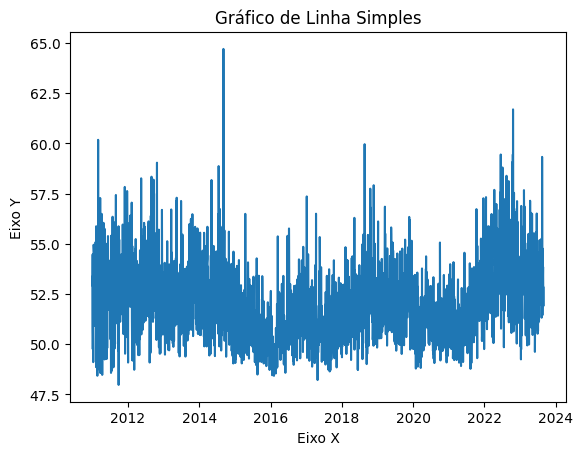

(array([2.110e+02, 1.016e+03, 1.063e+03, 5.690e+02, 2.000e+02, 6.000e+01,
        1.400e+01, 2.000e+00, 1.000e+00, 1.000e+00]),
 array([47.9668896 , 49.64100917, 51.31512875, 52.98924832, 54.66336789,
        56.33748746, 58.01160703, 59.6857266 , 61.35984617, 63.03396575,
        64.70808532]),
 <BarContainer object of 10 artists>)

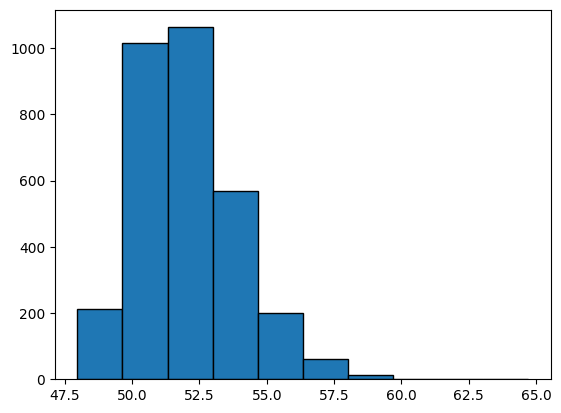

In [ ]:
indicator_rsi = ta.momentum.RSIIndicator(close = cotacoes["preco_fechamento"], window = 14)
cotacoes['rsi'] = indicator_rsi.rsi()

df_rsi = cotacoes
df_rsi = df_rsi[['data', 'ticker','rsi']]
df_rsi.columns = ['data', 'ticker','valor']

df_rsi['data'] = pd.to_datetime(df_rsi['data'])
teste = df_rsi.loc[df_rsi['data'] > '2011-01-01']

teste = teste.loc[teste['ticker'] == 'PETR4']

# Criar o gráfico de linha
plt.plot(teste['data'], teste['valor'])
plt.xlabel('Eixo X')
plt.ylabel('Eixo Y')
plt.title('Gráfico de Linha Simples')
plt.show()
plt.hist(teste['valor'], edgecolor='black')

<ipython-input-42-25f60f97e867>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stch['data'] = pd.to_datetime(df_stch['data'])


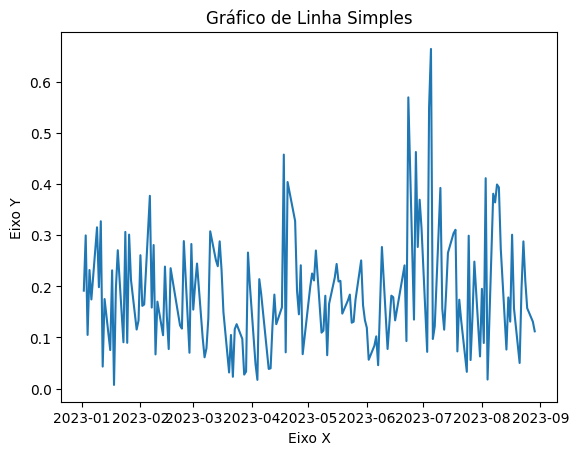

In [ ]:
indicator_stch = ta.momentum.StochRSIIndicator(close = cotacoes["preco_fechamento"], window = 14, smooth1 = 3, smooth2 = 3)
cotacoes['stch'] = indicator_stch.stochrsi()

df_stch = cotacoes
df_stch = df_stch[['data', 'ticker','stch']]
df_stch.columns = ['data', 'ticker','valor']

df_stch['data'] = pd.to_datetime(df_stch['data'])
teste = df_stch.loc[df_stch['data'] > '2023-01-01']

teste = teste.loc[teste['ticker'] == 'LWSA3']

# Criar o gráfico de linha
plt.plot(teste['data'], teste['valor'])
plt.xlabel('Eixo X')
plt.ylabel('Eixo Y')
plt.title('Gráfico de Linha Simples')
plt.show()

<ipython-input-36-9ff0f770f17f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_atr['data'] = pd.to_datetime(df_atr['data'])


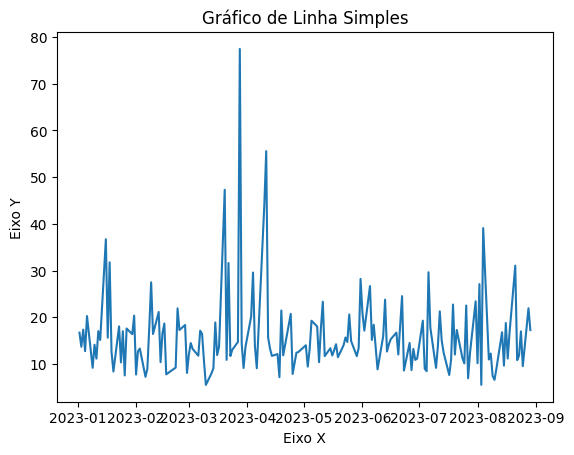

In [ ]:
indicator_atr = ta.volatility.AverageTrueRange(high = cotacoes['preco_maximo'], low = cotacoes['preco_minimo'], close = cotacoes['preco_fechamento'], window = 7)
cotacoes['atr'] = indicator_atr.average_true_range()

df_atr = cotacoes
df_atr = df_atr[['data', 'ticker','atr']]
df_atr.columns = ['data', 'ticker','valor']

df_atr['data'] = pd.to_datetime(df_atr['data'])
teste = df_atr.loc[df_atr['data'] > '2023-01-01']

teste = teste.loc[teste['ticker'] == 'LWSA3']

# Criar o gráfico de linha
plt.plot(teste['data'], teste['valor'])
plt.xlabel('Eixo X')
plt.ylabel('Eixo Y')
plt.title('Gráfico de Linha Simples')
plt.show()

In [ ]:
indicator_rsi = ta.momentum.RSIIndicator(close = cotacoes["preco_fechamento"], window = 14)
cotacoes['rsi'] = indicator_rsi.rsi()

df_rsi = cotacoes
df_rsi = df_rsi[['data', 'ticker','rsi']]
df_rsi.columns = ['data', 'ticker','valor']

df_rsi['data'] = pd.to_datetime(df_rsi['data'])
teste = df_rsi.loc[df_rsi['data'] > '2011-01-01']

teste = teste.loc[teste['ticker'] == 'PETR4']

# Criar o gráfico de linha
plt.plot(teste['data'], teste['valor'])
plt.xlabel('Eixo X')
plt.ylabel('Eixo Y')
plt.title('Gráfico de Linha Simples')
plt.show()
plt.hist(teste['valor'], edgecolor='black')

In [ ]:
cotacoes['data'] = pd.to_datetime(cotacoes['data']).dt.date
cotacoes = cotacoes[['data', 'ticker', 'preco_abertura','preco_maximo','preco_minimo','preco_fechamento','volume_negociado']]
df[['ticker','preco_abertura','preco_maximo','preco_minimo','preco_fechamento','volume_negociado']] = cotacoes.groupby('ticker')[['ticker','preco_abertura','preco_maximo','preco_minimo','preco_fechamento','volume_negociado']].fillna(0)

df1 = ta.add_all_ta_features(df, open="preco_abertura", high="preco_maximo", low="preco_minimo", close="preco_fechamento", volume="volume_negociado", fillna=True)

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:57: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)
/usr/local/lib/python3.10/dist-packages/ta/trend.py:780: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
/usr/local/lib/python3.10/dist-packages/ta/trend.py:785: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
df1.columns

Index(['data', 'preco_fechamento', 'preco_abertura', 'preco_maximo',
       'preco_minimo', 'volume_negociado', 'ticker', 'volume_adi',
       'volume_obv', 'volume_cmf', 'volume_fi', 'volume_em', 'volume_sma_em',
       'volume_vpt', 'volume_vwap', 'volume_mfi', 'volume_nvi',
       'volatility_bbm', 'volatility_bbh', 'volatility_bbl', 'volatility_bbw',
       'volatility_bbp', 'volatility_bbhi', 'volatility_bbli',
       'volatility_kcc', 'volatility_kch', 'volatility_kcl', 'volatility_kcw',
       'volatility_kcp', 'volatility_kchi', 'volatility_kcli',
       'volatility_dcl', 'volatility_dch', 'volatility_dcm', 'volatility_dcw',
       'volatility_dcp', 'volatility_atr', 'volatility_ui', 'trend_macd',
       'trend_macd_signal', 'trend_macd_diff', 'trend_sma_fast',
       'trend_sma_slow', 'trend_ema_fast', 'trend_ema_slow',
       'trend_vortex_ind_pos', 'trend_vortex_ind_neg', 'trend_vortex_ind_diff',
       'trend_trix', 'trend_mass_index', 'trend_dpo', 'trend_kst',
       'tren

#Visualização dos dados

In [ ]:
import pandas as pd
import numpy as np

pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [ ]:
#df1 = pd.read_parquet('/content/drive/MyDrive/Colab Notebooks/Carteira_Quant/base_dados_br/cotacoes.parquet')
df1 = pd.read_parquet('/content/drive/MyDrive/Colab Notebooks/Carteira_Quant/base_dados_br/dividend_yield.parquet')
#df3 = pd.read_parquet('/content/drive/MyDrive/Colab Notebooks/Carteira_Quant/base_dados_br/LucroLiquido12m.parquet')
df1

,data,ticker,valor
0,2011-01-03,BBDC4,0.000440
1,2011-01-03,BBDC3,0.000508
2,2011-01-05,DIRR3,0.022869
3,2011-01-07,LAME4,0.000658
4,2011-01-07,LAME3,0.000769
...,...,...,...
5911,2023-09-22,VIVT3,0.002758
5912,2023-09-22,ODPV3,0.003338
5913,2023-09-25,CMIG4,0.014679
5914,2023-09-25,TFCO4,0.002994


In [ ]:
df1.loc[df1['ticker'] == 'CGRA4']

,data,ticker,valor


In [ ]:
df = pd.read_parquet('/content/drive/MyDrive/Colab Notebooks/Carteira_Quant/base_dados_br/indicador_volume_mediano.parquet')
df

,data,ticker,valor
0,2010-02-02,BRIV3,15412.0
1,2010-02-02,CCRO3,35630047.0
2,2010-02-02,SFSA4,457994.0
3,2010-02-02,CLAN4,0.0
4,2010-02-02,BPNM4,3275639.0
...,...,...,...
1608896,2023-08-29,MNDL3,26500.0
1608897,2023-08-29,EZTC3,58357153.0
1608898,2023-08-29,CMIG3,6604204.0
1608899,2023-08-29,ABEV3,290702017.0


In [ ]:
df = pd.read_parquet('/content/drive/MyDrive/Colab Notebooks/Carteira_Quant/base_dados_br/rsi_14.parquet')
df

,data,ticker,valor
0,2010-01-04,CARD3,77.586655
1,2010-01-04,MNDL3,76.008802
2,2010-01-04,ESTC3,87.849275
3,2010-01-04,MMXM3,86.483913
4,2010-01-04,CTIP3,85.911987
...,...,...,...
1130197,2023-10-10,AMER3,77.122211
1130198,2023-10-10,CSED3,81.452933
1130199,2023-10-10,TOTS3,87.974137
1130200,2023-10-10,LAVV3,82.567674


In [ ]:
# Converter a coluna 'data' para o formato de data
df['data'] = pd.to_datetime(df['data'])

# Extrair o mês e o ano da coluna 'data'
df['ano'] = df['data'].dt.year
df['mes'] = df['data'].dt.month

# Inicializar um DataFrame vazio para armazenar os resultados
df_mensal_resumido = pd.DataFrame()

# Iterar sobre os tickers únicos
for ticker in df['ticker'].unique():
    df_ticker = df[df['ticker'] == ticker]

    # Agrupar por ano e mês, somando os valores
    df_ticker_mensal = df_ticker.groupby(['ano', 'mes'])['valor'].mean().reset_index()

    # Adicionar o ticker como coluna
    df_ticker_mensal['ticker'] = ticker

    # Concatenar com o DataFrame de resultados
    df_mensal_resumido = pd.concat([df_mensal_resumido, df_ticker_mensal])

df_mensal_resumido

,ano,mes,valor,ticker
0,2013,1,0.623056,LPSB3
1,2013,2,0.620592,LPSB3
2,2013,3,0.611784,LPSB3
3,2013,4,0.607823,LPSB3
4,2013,5,0.618361,LPSB3
...,...,...,...,...
0,2023,7,1.038426,AMBP3
1,2023,8,1.042195,AMBP3
0,2023,8,1.308833,SOMA3
0,2023,8,1.266673,LJQQ3


In [ ]:
df1.loc[df1['valor'] > 0.9]

,data,ticker,valor
281,2011-04-29,EQTL3,0.952381
453,2011-07-29,TRPN3,0.976734
638,2011-11-16,RANI3,0.916380
996,2012-04-26,CPLE5,0.981071
2034,2013-11-26,CPLE3,0.961322
2390,2014-04-29,SOND6,0.910544
2703,2014-11-06,CPLE5,0.943206
4334,2017-07-27,UNIP5,0.996777


(array([4706.,  442.,  120.,   58.,   38.,   22.,   15.,    9.,    8.,
           8.]),
 array([0.01000591, 0.10868301, 0.20736011, 0.30603721, 0.40471431,
        0.50339141, 0.60206851, 0.70074561, 0.79942271, 0.89809981,
        0.99677691]),
 <BarContainer object of 10 artists>)

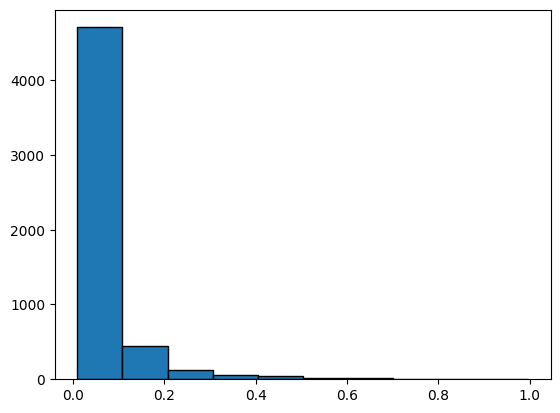

In [ ]:
df1 = df1[(df1['valor'] > 0.01) & (df1['valor'] < 1)]
plt.hist(df1['valor'], edgecolor='black')

(array([5.17251e+05, 1.63003e+05, 1.73320e+04, 4.06500e+03, 1.39800e+03,
        1.05100e+03, 1.90000e+02, 8.00000e+01, 3.72000e+02, 7.40000e+01]),
 array([0.01346808, 0.15725598, 0.30104387, 0.44483177, 0.58861966,
        0.73240756, 0.87619546, 1.01998335, 1.16377125, 1.30755915,
        1.45134704]),
 <BarContainer object of 10 artists>)

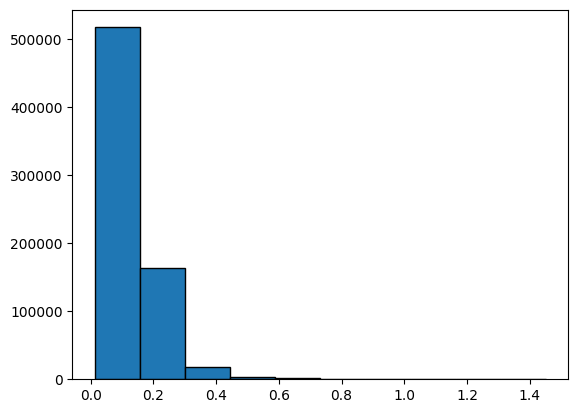

In [ ]:
# Plotar o histograma
# df_unique['valor'] = pd.qcut(df_unique['valor'], 10, labels = False)
#plt.figure(figsize=(10, 6))
df2 = df2[df2['valor'] < 2]
plt.hist(df2['valor'], edgecolor='black')

(array([  2565., 183627., 247282., 128688.,  67337.,  33235.,  15875.,
          9167.,   4574.,   3277.]),
 array([0.00646986, 0.02582156, 0.04517327, 0.06452497, 0.08387668,
        0.10322838, 0.12258009, 0.1419318 , 0.1612835 , 0.18063521,
        0.19998691]),
 <BarContainer object of 10 artists>)

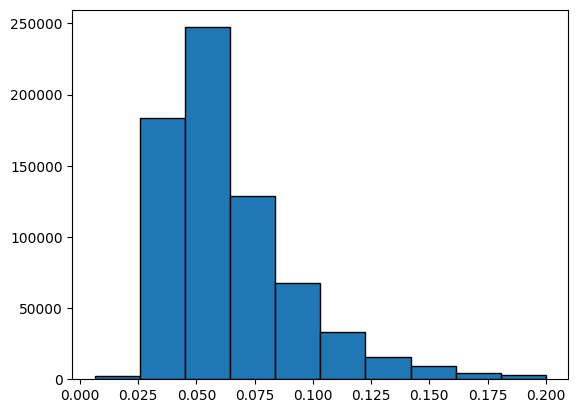

In [ ]:
df3 = df3[df3['valor'] < 0.2]
plt.hist(df3['valor'], edgecolor='black')

Beta    Axes(0.125,0.11;0.775x0.77)
dtype: object

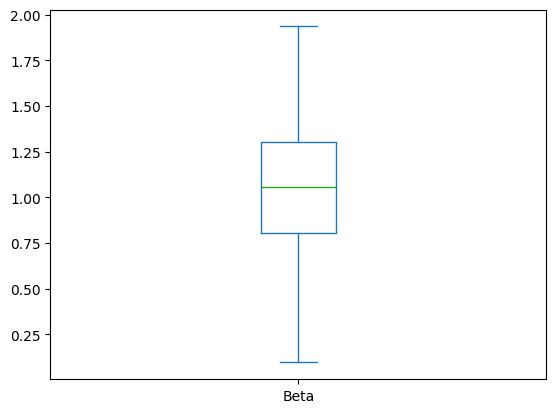

In [ ]:
betas.plot(kind='box',subplots=True )

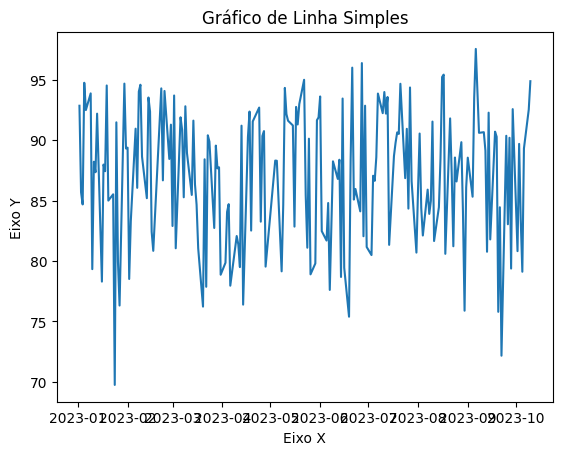

In [ ]:
df = pd.read_parquet('/content/drive/MyDrive/Colab Notebooks/Carteira_Quant/base_dados_br/rsi_14.parquet')
df['data'] = pd.to_datetime(df['data'])
teste = df.loc[df['ticker'] == 'PETR4']
teste = teste[teste['data'] >= '2023-01-01']
# Criar o gráfico de linha
plt.plot(teste['data'], teste['valor'])

# Adicionar rótulos aos eixos x e y
plt.xlabel('Eixo X')
plt.ylabel('Eixo Y')

# Adicionar um título ao gráfico
plt.title('Gráfico de Linha Simples')

# Exibir o gráfico
plt.show()

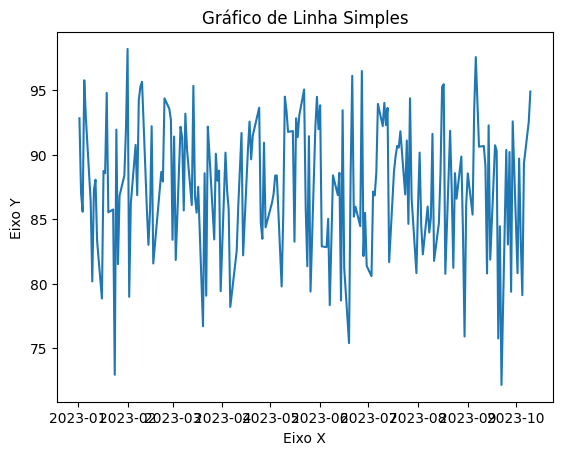

In [ ]:
df = pd.read_parquet('/content/drive/MyDrive/Colab Notebooks/Carteira_Quant/base_dados_br/rsi_14.parquet')
df['data'] = pd.to_datetime(df['data'])
teste = df.loc[df['ticker'] == 'PETR4']
teste = teste[teste['data'] >= '2023-01-01']
# Criar o gráfico de linha
plt.plot(teste['data'], teste['valor'])

# Adicionar rótulos aos eixos x e y
plt.xlabel('Eixo X')
plt.ylabel('Eixo Y')

# Adicionar um título ao gráfico
plt.title('Gráfico de Linha Simples')

# Exibir o gráfico
plt.show()

#Calculo dos Betas

In [ ]:
import yfinance as yf

In [ ]:
def betas(markets, stocks, start_date, end_date):
    # Calculate the beta by correlation and standard deviation

    # Download the historical data for the index/market
    market = yf.download(markets, start_date, end_date)
    market["stock_name"] = markets

    # Calculate daily returns
    market["daily_return"] = market["Adj Close"].pct_change(1)

    # Calculate standard deviation of the returns
    market_std = market["daily_return"].std()

    # Drop NaN values and select relevant columns
    market = market.dropna(subset = ["daily_return"])[["Adj Close", "stock_name", "daily_return"]]

    # Download the historical data for each stock and calculate its standard deviation
    stocks_data = []
    stds = []
    for stock in stocks:
        stock_data = yf.download(stock, start_date, end_date)
        stock_data["ticker"] = stock
        stock_data["daily_return"] = stock_data["Adj Close"].pct_change(1)
        stock_data.dropna(inplace=True)
        stock_data = stock_data[["Close", "ticker", "daily_return"]]
        stocks_data.append(stock_data)
        stds.append(stock_data["daily_return"].std())

    # Calculate the correlation between each stock and the index/market
    stock_correlation = []
    for stock_data in stocks_data:
        correlation = stock_data["daily_return"].corr(market["daily_return"])
        stock_correlation.append(correlation)

    # Calculate the beta
    betas = [correlation * (std / market_std) for correlation, std in zip(stock_correlation, stds)]

    # Create data frame
    dictionary = {stock: beta for stock, beta in zip(stocks, betas)}
    dataframe = pd.DataFrame.from_dict(dictionary, orient = "index", columns = ["Beta"]).reset_index()
    dataframe.rename(columns = {"index": "ticker"}, inplace = True)

    return dataframe


In [ ]:
# Get the list of the tickers listed in the B3 index and adds a .SA in the end

tickers = pd.read_html("https://en.wikipedia.org/wiki/List_of_companies_listed_on_B3")
table = tickers[0]
df = table[table["Ticker"].str.contains("BRK.B|BF.B") == False]
ticker_list = df["Ticker"].to_list()
ticker_list = [x + ".SA" for x in ticker_list]
ticker_list


In [ ]:
betas = betas("^BVSP", ticker_list, "2020-08-27", "2023-08-28")

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['BIDI11.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['BRML3.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['SULA11.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['LCAM3.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [ ]:
# Para limpar os tickers não encontrados
betas.dropna(inplace = True)
betas

,ticker,Beta
0,ALPA4.SA,1.092561
1,ABEV3.SA,0.723499
2,AMER3.SA,1.411096
3,AZUL4.SA,1.840490
4,B3SA3.SA,1.272227
...,...,...
83,USIM5.SA,1.247898
84,VALE3.SA,0.841151
85,VIIA3.SA,1.617631
86,YDUQ3.SA,1.481911


In [ ]:
betas.to_parquet('/content/drive/MyDrive/Colab Notebooks/Carteira_Quant/base_dados_br/indicador_betas.parquet')

In [ ]:
betas.loc[betas['ticker'] == 'KLBN11.SA']

,ticker,Beta
51,KLBN11.SA,0.380991


#Testes

In [ ]:
df = pd.read_parquet('/content/drive/MyDrive/Colab Notebooks/Carteira_Quant/base_dados_br/dividend_yield.parquet')
df[df['ticker'] == 'SAPR4']

,data,ticker,valor
248,2011-06-30,SAPR4,0.036506
443,2011-12-29,SAPR4,0.033079
679,2012-06-29,SAPR4,0.020824
871,2012-12-28,SAPR4,0.016632
1001,2013-04-25,SAPR4,0.014151
1107,2013-06-28,SAPR4,0.024132
1314,2013-12-30,SAPR4,0.022391
1441,2014-04-25,SAPR4,0.024607
1559,2014-06-30,SAPR4,0.031200
1770,2014-12-30,SAPR4,0.031729


In [ ]:
df = cotacoes.groupby('ticker')
df
2021 =
2022 = 0,083

In [ ]:
df1 = ta.add_all_ta_features(df, open="preco_abertura", high="preco_maximo", low="preco_minimo", close="preco_fechamento", volume="volume_negociado", fillna=True)

In [ ]:
df.describe()

,valor
count,1.357709e+06
mean,4.899519e+15
std,1.518138e+17
min,-7.827639e+09
25%,2.857060e-01
50%,8.265586e-01
75%,1.979187e+00
max,5.707712e+18


In [ ]:
df.loc[df['valor'] > 0].sort_values(by='valor', ascending=False).head(10)

,data,ticker,valor
276038,2013-09-16,VSPT3,5.707712e+18
282483,2013-10-07,VSPT3,5.707712e+18
265382,2013-08-13,VSPT3,5.707712e+18
278776,2013-09-24,VSPT3,5.707712e+18
284197,2013-10-11,VSPT3,5.707712e+18
269233,2013-08-23,VSPT3,5.707712e+18
271601,2013-09-02,VSPT3,5.707712e+18
266308,2013-08-15,VSPT3,5.707712e+18
289995,2013-10-30,VSPT3,5.707712e+18
287718,2013-10-23,VSPT3,5.707712e+18


In [ ]:
df.loc[df['ticker'] == 'ITUB4']

,data,ticker,valor
312,2011-02-22,ITUB4,652.207149
352,2011-02-23,ITUB4,654.795273
353,2011-02-23,ITUB4,0.654795
408,2011-02-24,ITUB4,0.648972
456,2011-02-25,ITUB4,0.646384
...,...,...,...
1355340,2023-08-10,ITUB4,1.431643
1356211,2023-08-11,ITUB4,1.434238
1356797,2023-08-14,ITUB4,1.413482
1357150,2023-08-15,ITUB4,1.405698


In [ ]:
df = pd.read_parquet('/content/drive/MyDrive/Colab Notebooks/Carteira_Quant/base_dados_br/LucroLiquido.parquet')
df = df.loc[df['data'] == '2012-10-23']
df = df.loc[df['ticker'] == 'ITUB4']
df.loc[df['valor'] >=	0].sort_values(by='valor', ascending=True).head(5)

,ticker,cnpj,item,data,valor
1537478,ITUB4,60.872.504/0001-23,LucroLiquido,2012-10-23,2.705231e+09
1537479,ITUB4,60.872.504/0001-23,LucroLiquido,2012-10-23,2.776157e+09


In [ ]:
df = pd.read_parquet('/content/drive/MyDrive/Colab Notebooks/Carteira_Quant/base_dados_br/LucroLiquido12m.parquet')
df = df.loc[df['data'] == '2012-10-23']
df = df.loc[df['ticker'] == 'ITUB4']
df.loc[df['valor'] >=	0].sort_values(by='valor', ascending=True).head(5)

,ticker,cnpj,item,data,valor
1456974,ITUB4,60.872.504/0001-23,LucroLiquido12m,2012-10-23,1.039884e+10
1456973,ITUB4,60.872.504/0001-23,LucroLiquido12m,2012-10-23,1.162045e+10


In [ ]:
df = pd.read_parquet('/content/drive/MyDrive/Colab Notebooks/Carteira_Quant/base_dados_br/ReceitaLiquida12m.parquet')
df = df.loc[df['data'] == '2012-12-31']
df = df.loc[df['ticker'] == 'ITUB4']
df.loc[df['valor'] <=	0].sort_values(by='valor', ascending=True).head(5)

,ticker,cnpj,item,data,valor
1456337,ITUB4,60.872.504/0001-23,ReceitaLiquida12m,2012-12-31,-2.212375e+10


In [ ]:
df = pd.read_parquet('/content/drive/MyDrive/Colab Notebooks/Carteira_Quant/base_dados_br/LucroLiquido12m.parquet')
contagem_repeticoes = df.groupby(['data', 'ticker']).size().reset_index(name='contagem')

contagem_repeticoes[contagem_repeticoes['contagem'] > 1]

,data,ticker,contagem
500,2011-11-03,EQTL3,2
2062,2011-11-11,PINE3,2
2063,2011-11-11,PINE4,2
4719,2011-11-17,DEXP3,2
4720,2011-11-17,DEXP4,2
...,...,...,...
2640533,2023-08-15,PPLA11,2
2640551,2023-08-15,RCSL3,2
2640552,2023-08-15,RCSL4,2
2640641,2023-08-15,TELB3,2


In [ ]:
df.loc[(df['data'] == '2011-11-03') & (df['ticker'] == 'EQTL3')]


,ticker,cnpj,item,data,valor
1098561,EQTL3,03.220.438/0001-73,LucroLiquido12m,2011-11-03,240846000.0
1098562,EQTL3,03.220.438/0001-73,LucroLiquido12m,2011-11-03,154092000.0


In [ ]:
df = pd.read_parquet('/content/drive/MyDrive/Colab Notebooks/Carteira_Quant/base_dados_br/LucroLiquido.parquet')
df = df.loc[df['data'] >= '2011-12-31']
df = df.loc[df['ticker'] == 'PETR4']
df.loc[df['valor'] <=	0].sort_values(by='valor', ascending=True).head(5)

,ticker,cnpj,item,data,valor
2000320,PETR4,33.000.167/0001-01,LucroLiquido,2020-07-17,-4.972400e+10
2000329,PETR4,33.000.167/0001-01,LucroLiquido,2020-07-26,-4.972400e+10
2000330,PETR4,33.000.167/0001-01,LucroLiquido,2020-07-27,-4.972400e+10
2000331,PETR4,33.000.167/0001-01,LucroLiquido,2020-07-28,-4.972400e+10
2000332,PETR4,33.000.167/0001-01,LucroLiquido,2020-07-29,-4.972400e+10


In [ ]:
df = df.loc[df['ticker'] == 'ITSA4']
df.loc[df['valor'] > 0 ]

,ticker,cnpj,indicador,data,valor
1840799,ITSA4,61.532.644/0001-15,EV_EBIT,2011-11-08,1.83624
1840800,ITSA4,61.532.644/0001-15,EV_EBIT,2011-11-09,1.83624
1840801,ITSA4,61.532.644/0001-15,EV_EBIT,2011-11-09,1.87802
1840802,ITSA4,61.532.644/0001-15,EV_EBIT,2011-11-10,1.87802
1840803,ITSA4,61.532.644/0001-15,EV_EBIT,2011-11-10,1.90004
...,...,...,...,...,...
1848009,ITSA4,61.532.644/0001-15,EV_EBIT,2023-08-14,6.74519
1848010,ITSA4,61.532.644/0001-15,EV_EBIT,2023-08-14,6.29086
1848011,ITSA4,61.532.644/0001-15,EV_EBIT,2023-08-15,6.29086
1848012,ITSA4,61.532.644/0001-15,EV_EBIT,2023-08-15,6.27006


In [ ]:
df = pd.read_parquet('/content/drive/MyDrive/Colab Notebooks/Carteira_Quant/base_dados_br/EV_EBIT.parquet')
df = df.loc[df['ticker'] == 'ITSA4']
df.loc[df['data'] == '2013-12-31' ]

,ticker,cnpj,indicador,data,valor
1842114,ITSA4,61.532.644/0001-15,EV_EBIT,2013-12-31,-4.75749


In [ ]:
df = pd.read_parquet('/content/drive/MyDrive/Colab Notebooks/Carteira_Quant/base_dados_br/EBIT_EV.parquet')
df = df.loc[df['ticker'] == 'ITSA4']
df.loc[df['data'] == '2013-12-31' ]

,ticker,cnpj,indicador,data,valor
1848936,ITSA4,61.532.644/0001-15,EBIT_EV,2013-12-31,-0.2102


In [ ]:
ev = pd.read_parquet('/content/drive/MyDrive/Colab Notebooks/Carteira_Quant/base_dados_br/EV.parquet')
ebit = pd.read_parquet('/content/drive/MyDrive/Colab Notebooks/Carteira_Quant/base_dados_br/Ebit12m.parquet')

In [ ]:
ev = ev.loc[ev['ticker'] == 'ITSA4']
ev.loc[ev['data'] == '2013-12-31' ]

,ticker,cnpj,indicador,data,valor
1971716,ITSA4,61.532.644/0001-15,EV,2013-12-31,5.789860e+10


In [ ]:
ebit = ebit.loc[ebit['ticker'] == 'ITSA4']
ebit.loc[ebit['data'] == '2013-12-31' ]

,ticker,cnpj,item,data,valor
1448707,ITSA4,61.532.644/0001-15,Ebit12m,2013-12-31,-1.217000e+10


In [ ]:
(ev.loc[1971716, 'valor'])/(ebit.loc[1448707, 'valor'])

-4.757485529991783

In [ ]:
(ebit.loc[1448707, 'valor'])/(ev.loc[1971716, 'valor'])

-0.21019506915909153